Looking at how the choice of region to test affects the results.   
We can use the whole gene, part of the gene, or exclude certain types of mutations (from both the null and the observed distributions).  

We use the ligand-binding interface in EGF11-12 as the example case.   

Have already seen the results of restricting to EGF11-12 and excluding destabilising mutations.  
Just look at the case of using the whole gene with no exclusions.   

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum, TranscriptKmerSpectrum, EvenMutationalSpectrum
from darwinian_shift import CDFPermutationTest, ChiSquareTest, PermutationTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

In [3]:
from darwinian_shift.additional_plotting_functions import plot_scatter_two_scores

In [4]:
from darwinian_shift.utils.sifts_functions import get_sifts_alignment
import os

# Setup

In [5]:
# Load data
data = pd.read_excel("aau3879_TableS2.xlsx", skiprows=17, sheet_name='Mutations_collapsed_by_distance')

In [6]:
egf11_12_interface_residues = [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                               435, 436, 444, 447, 448, 450, 451, 452, 454, 
                               466, 467, 468, 469, 470, 471, 475, 477, 478, 
                               479, 480]

In [7]:
len(egf11_12_interface_residues)

29

In [8]:
# Define the regions to test. 
section_definition_whole_gene = {
    'transcript_id': 'ENST00000277541', 'interface_residues': egf11_12_interface_residues
}

# Need to define the pdb file and chain to use the FoldX results. 
section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488, # Restrict to the residues in EGF11-12
    'interface_residues': egf11_12_interface_residues
}

In [9]:
# Define the interface lookup
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

In [10]:
# Define the mutational spectra
spectrum=GlobalKmerSpectrum(
        k=3,  # Use a trinucleotide context,
        ignore_strand=False,  # Transcribed strand of the protein matters, so have 192 different mutation types
        deduplicate_spectrum=False,  # Do not remove duplicate mutations when calculating the spectrum
        name=''  # Use a blank name, so in the plots it will just say "Expected"
    )

In [11]:
# Define the statistical tests
cdf_perm = CDFPermutationTest(num_permutations=100000, testing_random_seed=0)  # Used to calculate main text p-values

chi_sq = ChiSquareTest(bins=[-0.1, 0.5, 1.1])  # Used to calculate counts for the discrete metrics

stats = [cdf_perm, chi_sq]

In [12]:
# Make a DarwinianShift object for the project. 
# This calculates the mutational spectrum, sets up the statistical tests to use, and filters the data. 
d = DarwinianShift(
    data=data, 
    source_genome='GRCh37',
    spectra=spectrum,
    stats=stats,
    lookup=interface_lookup,
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

In [13]:
plot_directory="./Supp_figures/"
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)
    
sifts_directory="."
pdb_directory = "."

In [14]:
# Colours

unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'

foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'

interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'

calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Whole gene

In [15]:
whole_gene = d.run_section(section_definition_whole_gene)

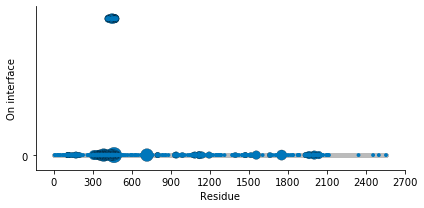

In [16]:
whole_gene.plot_scatter(figsize=(6, 3), plot_scale='symlog', show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=interface_observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.tight_layout()

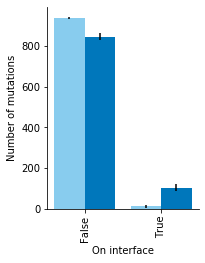

In [17]:
whole_gene.plot_binned_counts(figsize=(3, 4), show_legend=False, 
                          colours=[interface_observed_colour, interface_expected_colour])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_whole_gene_interface.pdf'), transparent=True)

In [18]:
whole_gene_results = whole_gene.get_results_dictionary()

In [19]:
whole_gene_results['num_mutations']

951

In [20]:
whole_gene_results['CDF_perm__pvalue']  # P-value of the permutation test

1.999980000199998e-05

# Randomised residues in EGF11-12 tested against the whole gene

In [21]:
pvals_from_random_egf11_12_residues = []
random_expected_off = []
random_expected_on = []
random_observed_off = []
random_observed_on = []
for i in range(1000):
    np.random.seed(i)
    random_residues = np.random.choice(np.arange(412, 489), size=len(egf11_12_interface_residues), replace=False)
    section = {'transcript_id': 'ENST00000277541', 'interface_residues': random_residues}
    s = d.run_section(section)
    res = s.get_results_dictionary()
    print(i, res['CDF_perm__pvalue'],  res['chi_square__expected_counts'], res['chi_square__observed_counts'],)
    pvals_from_random_egf11_12_residues.append(res['CDF_perm__pvalue'])
    random_observed_off.append(res['chi_square__observed_counts'][0])
    random_observed_on.append(res['chi_square__observed_counts'][1])
    random_expected_off.append(res['chi_square__expected_counts'][0])
    random_expected_on.append(res['chi_square__expected_counts'][1])

0 1.999980000199998e-05 [939.84157418  11.15842582] [822 129]
1 1.999980000199998e-05 [940.0253419  10.9746581] [822 129]
2 1.999980000199998e-05 [939.97948325  11.02051675] [851 100]
3 1.999980000199998e-05 [938.60670981  12.39329019] [824 127]
4 1.999980000199998e-05 [939.12718052  11.87281948] [837 114]
5 1.999980000199998e-05 [939.75770526  11.24229474] [832 119]
6 1.999980000199998e-05 [939.00397665  11.99602335] [860  91]
7 1.999980000199998e-05 [938.3515404  12.6484596] [837 114]
8 1.999980000199998e-05 [939.50656111  11.49343889] [852  99]
9 1.999980000199998e-05 [938.90885108  12.09114892] [814 137]
10 1.999980000199998e-05 [939.5539315  11.4460685] [823 128]
11 1.999980000199998e-05 [940.11021394  10.88978606] [842 109]
12 1.999980000199998e-05 [939.40028152  11.59971848] [821 130]
13 1.999980000199998e-05 [938.93139496  12.06860504] [861  90]
14 1.999980000199998e-05 [939.48040027  11.51959973] [877  74]
15 1.999980000199998e-05 [938.58554014  12.41445986] [860  91]
16 1.999

131 1.999980000199998e-05 [939.38537613  11.61462387] [837 114]
132 1.999980000199998e-05 [939.93179823  11.06820177] [806 145]
133 1.999980000199998e-05 [939.36061556  11.63938444] [808 143]
134 1.999980000199998e-05 [938.82404295  12.17595705] [831 120]
135 1.999980000199998e-05 [939.7426443  11.2573557] [859  92]
136 1.999980000199998e-05 [937.97941429  13.02058571] [830 121]
137 1.999980000199998e-05 [938.74159628  12.25840372] [842 109]
138 1.999980000199998e-05 [938.8679087  12.1320913] [824 127]
139 1.999980000199998e-05 [939.83928359  11.16071641] [882  69]
140 1.999980000199998e-05 [939.17163023  11.82836977] [845 106]
141 1.999980000199998e-05 [939.75457028  11.24542972] [865  86]
142 1.999980000199998e-05 [940.4678997  10.5321003] [834 117]
143 1.999980000199998e-05 [938.91791709  12.08208291] [849 102]
144 1.999980000199998e-05 [940.32954009  10.67045991] [817 134]
145 1.999980000199998e-05 [939.64309564  11.35690436] [834 117]
146 1.999980000199998e-05 [939.68788481  11.31

260 1.999980000199998e-05 [939.92979628  11.07020372] [840 111]
261 1.999980000199998e-05 [939.29127143  11.70872857] [830 121]
262 1.999980000199998e-05 [939.03945933  11.96054067] [830 121]
263 1.999980000199998e-05 [940.39448496  10.60551504] [848 103]
264 1.999980000199998e-05 [939.1572673  11.8427327] [820 131]
265 1.999980000199998e-05 [939.75090525  11.24909475] [821 130]
266 1.999980000199998e-05 [938.30142212  12.69857788] [858  93]
267 1.999980000199998e-05 [938.91793351  12.08206649] [857  94]
268 1.999980000199998e-05 [937.1069968  13.8930032] [843 108]
269 1.999980000199998e-05 [939.44624221  11.55375779] [830 121]
270 1.999980000199998e-05 [938.083346  12.916654] [802 149]
271 1.999980000199998e-05 [940.07463552  10.92536448] [852  99]
272 1.999980000199998e-05 [940.34785837  10.65214163] [794 157]
273 1.999980000199998e-05 [939.24936411  11.75063589] [859  92]
274 1.999980000199998e-05 [939.14683915  11.85316085] [812 139]
275 1.999980000199998e-05 [939.34767218  11.6523

389 1.999980000199998e-05 [940.26143106  10.73856894] [859  92]
390 1.999980000199998e-05 [939.85398708  11.14601292] [838 113]
391 1.999980000199998e-05 [939.1101277  11.8898723] [844 107]
392 1.999980000199998e-05 [939.9563279  11.0436721] [832 119]
393 1.999980000199998e-05 [939.58350614  11.41649386] [809 142]
394 1.999980000199998e-05 [939.95790609  11.04209391] [811 140]
395 1.999980000199998e-05 [939.97168067  11.02831933] [867  84]
396 1.999980000199998e-05 [940.18967532  10.81032468] [842 109]
397 1.999980000199998e-05 [940.88057536  10.11942464] [832 119]
398 1.999980000199998e-05 [939.86369105  11.13630895] [856  95]
399 1.999980000199998e-05 [938.48996022  12.51003978] [839 112]
400 1.999980000199998e-05 [938.97821881  12.02178119] [810 141]
401 1.999980000199998e-05 [937.93500641  13.06499359] [823 128]
402 1.999980000199998e-05 [939.35323023  11.64676977] [837 114]
403 1.999980000199998e-05 [938.79545127  12.20454873] [838 113]
404 1.999980000199998e-05 [937.9632514  13.0

518 1.999980000199998e-05 [940.01964557  10.98035443] [862  89]
519 1.999980000199998e-05 [939.70153293  11.29846707] [814 137]
520 1.999980000199998e-05 [937.63272097  13.36727903] [819 132]
521 1.999980000199998e-05 [940.13391724  10.86608276] [852  99]
522 1.999980000199998e-05 [939.7219373  11.2780627] [834 117]
523 1.999980000199998e-05 [940.56782558  10.43217442] [843 108]
524 1.999980000199998e-05 [940.50666782  10.49333218] [846 105]
525 1.999980000199998e-05 [937.67374201  13.32625799] [801 150]
526 1.999980000199998e-05 [940.00054499  10.99945501] [823 128]
527 1.999980000199998e-05 [941.05003637   9.94996363] [800 151]
528 1.999980000199998e-05 [937.81430128  13.18569872] [858  93]
529 1.999980000199998e-05 [939.40566126  11.59433874] [817 134]
530 1.999980000199998e-05 [938.7108733  12.2891267] [827 124]
531 1.999980000199998e-05 [940.54057364  10.45942636] [852  99]
532 1.999980000199998e-05 [939.0910096  11.9089904] [840 111]
533 1.999980000199998e-05 [938.71340083  12.28

647 1.999980000199998e-05 [940.60480747  10.39519253] [839 112]
648 1.999980000199998e-05 [940.46249656  10.53750344] [826 125]
649 1.999980000199998e-05 [939.28093472  11.71906528] [817 134]
650 1.999980000199998e-05 [939.58506821  11.41493179] [860  91]
651 1.999980000199998e-05 [938.58290296  12.41709704] [849 102]
652 1.999980000199998e-05 [938.08068891  12.91931109] [829 122]
653 1.999980000199998e-05 [938.90927416  12.09072584] [805 146]
654 1.999980000199998e-05 [937.9964501  13.0035499] [849 102]
655 1.999980000199998e-05 [940.16146653  10.83853347] [876  75]
656 1.999980000199998e-05 [939.82049343  11.17950657] [830 121]
657 1.999980000199998e-05 [938.50943032  12.49056968] [814 137]
658 1.999980000199998e-05 [940.12538833  10.87461167] [837 114]
659 1.999980000199998e-05 [938.04895226  12.95104774] [867  84]
660 1.999980000199998e-05 [937.50695814  13.49304186] [812 139]
661 1.999980000199998e-05 [937.80511331  13.19488669] [833 118]
662 1.999980000199998e-05 [938.66936713  1

776 1.999980000199998e-05 [939.53235225  11.46764775] [856  95]
777 1.999980000199998e-05 [939.15574336  11.84425664] [826 125]
778 1.999980000199998e-05 [940.37385997  10.62614003] [846 105]
779 1.999980000199998e-05 [940.42316527  10.57683473] [824 127]
780 1.999980000199998e-05 [940.77046431  10.22953569] [876  75]
781 1.999980000199998e-05 [938.816018  12.183982] [810 141]
782 1.999980000199998e-05 [939.45776492  11.54223508] [843 108]
783 1.999980000199998e-05 [938.02615434  12.97384566] [864  87]
784 1.999980000199998e-05 [939.71361663  11.28638337] [818 133]
785 1.999980000199998e-05 [939.168039  11.831961] [835 116]
786 1.999980000199998e-05 [939.57553717  11.42446283] [855  96]
787 1.999980000199998e-05 [939.9834173  11.0165827] [855  96]
788 1.999980000199998e-05 [939.84741641  11.15258359] [835 116]
789 1.999980000199998e-05 [939.5773245  11.4226755] [813 138]
790 1.999980000199998e-05 [938.87467332  12.12532668] [822 129]
791 1.999980000199998e-05 [939.33861267  11.66138733

905 1.999980000199998e-05 [938.46170928  12.53829072] [827 124]
906 1.999980000199998e-05 [939.25806093  11.74193907] [837 114]
907 1.999980000199998e-05 [940.24536153  10.75463847] [811 140]
908 1.999980000199998e-05 [939.83304655  11.16695345] [855  96]
909 1.999980000199998e-05 [939.11033668  11.88966332] [832 119]
910 1.999980000199998e-05 [939.69772482  11.30227518] [819 132]
911 1.999980000199998e-05 [937.51827118  13.48172882] [821 130]
912 1.999980000199998e-05 [940.31158454  10.68841546] [840 111]
913 1.999980000199998e-05 [938.11508055  12.88491945] [804 147]
914 1.999980000199998e-05 [939.32271991  11.67728009] [821 130]
915 1.999980000199998e-05 [938.60842836  12.39157164] [836 115]
916 1.999980000199998e-05 [939.57868611  11.42131389] [859  92]
917 1.999980000199998e-05 [939.75596314  11.24403686] [828 123]
918 1.999980000199998e-05 [938.40258295  12.59741705] [813 138]
919 1.999980000199998e-05 [940.25689584  10.74310416] [832 119]
920 1.999980000199998e-05 [938.67827434 

In [22]:
max(pvals_from_random_egf11_12_residues)

1.999980000199998e-05

In [23]:
df = pd.DataFrame({
    'counts': np.concatenate([random_expected_on, random_expected_off, random_observed_on, random_observed_off]),
    'In subset': ['expected_on']*1000 + ['expected_off']*1000 + ['observed_on']*1000 + ['observed_off']*1000
})

In [24]:
import seaborn as sns
sns.set_style('white')

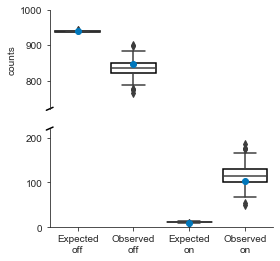

In [27]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 4))
sns.boxplot(data=df, x='In subset', y='counts', order=['expected_off', 'observed_off', 'expected_on', 'observed_on'], ax=ax)
sns.boxplot(data=df, x='In subset', y='counts', order=['expected_off', 'observed_off', 'expected_on', 'observed_on'], ax=ax2)
hide_top_and_right_axes(ax)
hide_top_and_right_axes(ax2)
ax.get_xaxis().set_visible(False)
ax.set_ylim(720, 1000)  # outliers only
ax2.set_ylim(0, 220)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.set_xlabel('')
ax2.set_xlabel('')

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Expected\noff', 'Observed\noff', 'Expected\non', 'Observed\non'])


diag = .015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-diag, +diag), (-diag, +diag), **kwargs)   
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-diag, +diag), (1 - diag, 1 + diag), **kwargs)

plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax2.artists, edgecolor = 'k', facecolor='w');

# The interface results
ax.scatter(range(4), [
    whole_gene_results['chi_square__expected_counts'][0], whole_gene_results['chi_square__observed_counts'][0],
    whole_gene_results['chi_square__expected_counts'][1], whole_gene_results['chi_square__observed_counts'][1],
], c=interface_observed_colour, zorder=4
)
ax2.scatter(range(4), [
    whole_gene_results['chi_square__expected_counts'][0], whole_gene_results['chi_square__observed_counts'][0],
    whole_gene_results['chi_square__expected_counts'][1], whole_gene_results['chi_square__observed_counts'][1],
], c=interface_observed_colour, zorder=4
)

ax2.set_ylabel('')

hide_top_and_right_axes(ax)
hide_top_and_right_axes(ax2)
plt.savefig(os.path.join(plot_directory, 'random_egf11_12_test_against_whole_gene_split.pdf'), transparent=True)